In [2]:
import xarray as xr
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping

# Define input and output file paths
netcdf_file = 'spei03.nc'
shapefile = '4state.shp'
output_file = 'SPEI3-1982-2022.nc' 

# Load the NetCDF file
ds = xr.open_dataset(netcdf_file)

# Assign CRS EPSG:4326 to the NetCDF file
ds = ds.rio.write_crs("EPSG:4326")

# Select bands corresponding to January 1982 to December 2022 (bands 972 to 1463)
ds_subset = ds.isel(time=slice(972, 1463))

# Load the shapefile and transform it to the CRS of the NetCDF file
shapefile_data = gpd.read_file(shapefile)
shapefile_data = shapefile_data.to_crs(ds.rio.crs)

# Convert the shapefile geometry to a mask
geometry = [mapping(geom) for geom in shapefile_data.geometry]

# Set spatial dimensions and apply the mask
ds_subset = ds_subset.rio.write_crs(ds.rio.crs)
masked_ds = ds_subset.rio.clip(geometry, shapefile_data.crs, drop=True)

# Remove 'grid_mapping' attribute before saving to avoid conflicts
for var in masked_ds.variables.values():
    if 'grid_mapping' in var.attrs:
        del var.attrs['grid_mapping']

# Save the masked dataset to a new NetCDF file
masked_ds.to_netcdf(output_file)

# Print a success message
print(f"Masked and time-filtered NetCDF file saved to '{output_file}'.")


Masked and time-filtered NetCDF file saved to 'SPEI3-1982-2022.nc'.


In [3]:
import xarray as xr
import numpy as np
from scipy import interpolate

# Load the original NetCDF file
netcdf_file = 'SPEI3-1982-2022.nc'
ds = xr.open_dataset(netcdf_file)

# Check the CRS and assign EPSG:4326 if necessary
ds = ds.rio.write_crs("EPSG:4326")

# Define the target grid (4 km x 4 km resolution)
lat_new = np.arange(ds.lat.min(), ds.lat.max(), 0.036)
lon_new = np.arange(ds.lon.min(), ds.lon.max(), 0.036)

# Create the new target grid as an xarray dataset
grid_new = xr.Dataset(
    {
        "lat": (["lat"], lat_new),
        "lon": (["lon"], lon_new),
    }
)

# Use xarray's linear interpolation to resample the data
ds_resampled = ds.interp(lat=lat_new, lon=lon_new, method="linear")

# Save the resampled dataset to a new NetCDF file
output_file = 'spei03_resampled.nc'
ds_resampled.to_netcdf(output_file)

# Print a success message
print(f"Resampled dataset saved to '{output_file}'.")

Resampled dataset saved to 'spei03_resampled.nc'.


In [1]:
import xarray as xr
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping

# Define input and output file paths
netcdf_file = 'spei03_CHIRPS.nc'
shapefile = '4state.shp'
output_file = 'SPI3_CHIRPS_clipped-1982-2022.nc'

# Load the NetCDF file using rioxarray
ds = rioxarray.open_rasterio(netcdf_file)

# Check if CRS is defined for the raster dataset
if ds.rio.crs is None:
    print("CRS not found in the raster dataset. You need to define it.")
    # Manually assign a CRS (Example: 'EPSG:4326' for WGS84, change if necessary)
    ds = ds.rio.write_crs("EPSG:4326", inplace=True)
    print("CRS assigned as EPSG:4326.")
else:
    print(f"CRS of the raster: {ds.rio.crs}")

# Load the shapefile (with the area to mask)
shapefile_data = gpd.read_file(shapefile)

# Convert the shapefile CRS to the CRS of the raster
shapefile_data = shapefile_data.to_crs(ds.rio.crs)

# Convert the shapefile geometry to a mask
geometry = [mapping(geom) for geom in shapefile_data.geometry]

# Apply the mask to the raster data (clipping the data based on the shapefile geometry)
masked_ds = ds.rio.clip(geometry, shapefile_data.crs, drop=True)

# Save the masked dataset to a new NetCDF file
masked_ds.to_netcdf(output_file)

# Print a success message
print(f"Masked NetCDF file saved as '{output_file}'.")

CRS not found in the raster dataset. You need to define it.
CRS assigned as EPSG:4326.
Masked NetCDF file saved as 'SPI3_CHIRPS_clipped-1982-2022.nc'.


In [14]:
import xarray as xr
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping

# Define file paths
netcdf_file = 'SPEI3_CHIRPS_clipped-1982-2022.nc'
shapefile = '4states.shp'  # Shapefile for the region (Illinois, Indiana, Iowa, Ohio)
output_file = 'SPEI3_CHIRPS_clipped_by_mask_with_CRS.nc'  # Output file path

# Load the NetCDF dataset using xarray
ds = xr.open_dataset(netcdf_file)

# Ensure the NetCDF dataset has the CRS (assign if not already assigned)
if ds.rio.crs is None:
    ds.rio.write_crs("EPSG:4326", inplace=True)  # Assign EPSG:4326 if no CRS is assigned

# Load the shapefile
shapefile_data = gpd.read_file(shapefile)

# Ensure CRS of the shapefile matches the CRS of the NetCDF dataset
if shapefile_data.crs != ds.rio.crs:
    shapefile_data = shapefile_data.to_crs(ds.rio.crs)

# Convert the shapefile geometry to a list of geometry dicts
geometry = [mapping(geom) for geom in shapefile_data.geometry]

# Apply the mask to the raster data (Clip the data using the shapefile geometry)
ds_masked = ds.rio.clip(geometry, shapefile_data.crs, drop=True)

# Remove the problematic attribute 'grid_mapping' from the variable's attributes
if 'grid_mapping' in ds_masked.spei.attrs:
    del ds_masked.spei.attrs['grid_mapping']

# Save the masked dataset to a new NetCDF file, keeping all properties
ds_masked.to_netcdf(output_file)

print(f"Masked NetCDF file saved as '{output_file}'.")

Masked NetCDF file saved as 'SPEI3_CHIRPS_clipped_by_mask_with_CRS.nc'.


In [17]:
import xarray as xr
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping

# Define file paths
netcdf_file = 'SPI3_clipped-1982-2022.nc'  # Input NetCDF file path
shapefile = '4states.shp'  # Shapefile for the region (Illinois, Indiana, Iowa, Ohio)
output_file = 'SPI3_clipped_by_mask_with_CRS.nc'  # Output file path

# Load the NetCDF dataset using xarray
ds = xr.open_dataset(netcdf_file)

# Ensure the NetCDF dataset has the CRS (assign if not already assigned)
if ds.rio.crs is None:
    ds.rio.write_crs("EPSG:4326", inplace=True)  # Assign EPSG:4326 if no CRS is assigned

# Load the shapefile
shapefile_data = gpd.read_file(shapefile)

# Ensure CRS of the shapefile matches the CRS of the NetCDF dataset
if shapefile_data.crs != ds.rio.crs:
    shapefile_data = shapefile_data.to_crs(ds.rio.crs)

# Convert the shapefile geometry to a list of geometry dicts
geometry = [mapping(geom) for geom in shapefile_data.geometry]

# Apply the mask to the raster data (Clip the data using the shapefile geometry)
ds_masked = ds.rio.clip(geometry, shapefile_data.crs, drop=True)

# Remove the problematic attribute 'grid_mapping' from the variable's attributes
if 'grid_mapping' in ds_masked.__xarray_dataarray_variable__.attrs:
    del ds_masked.__xarray_dataarray_variable__.attrs['grid_mapping']

# Save the masked dataset to a new NetCDF file, keeping all properties
ds_masked.to_netcdf(output_file)

print(f"Masked NetCDF file saved as '{output_file}'.")

Masked NetCDF file saved as 'SPI3_clipped_by_mask_with_CRS.nc'.


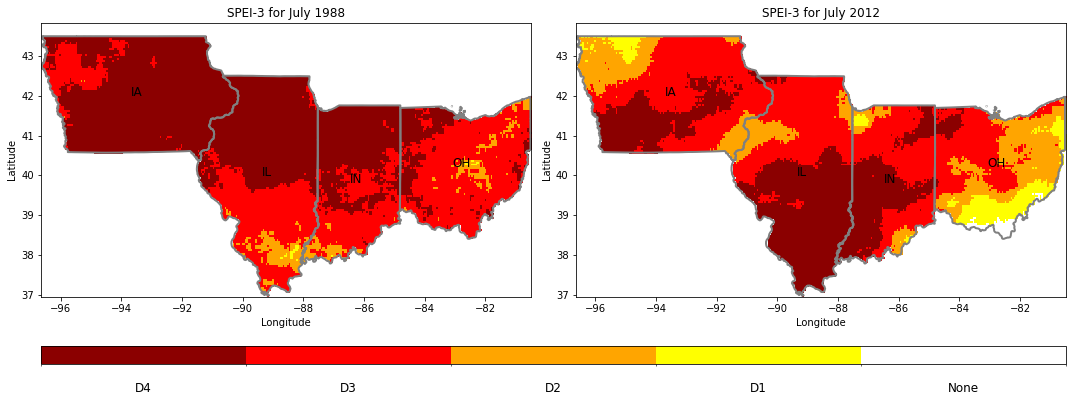

In [187]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec

# Load the NetCDF file
nc_file = "SPEI3_CHIRPS_clipped_by_mask_with_CRS.nc"
ds = xr.open_dataset(nc_file)

# Select Bands for June and July 2012
band_indices = [91 - 1, 379 - 1]  # Convert to 0-based indices (June 2012, July 2012)
spei_data = [ds["spei"].isel(time=band_index) for band_index in band_indices]

# Load the shapefile
shapefile = "4states.shp"
gdf = gpd.read_file(shapefile)

# Classify the SPEI data (Manualy change the thresholds to fixed or impacts-based)
class_bins = [-5, -2, -1.6, -1.3, -0.8, 5]
class_colors = ["darkred", "red", "orange", "yellow", "white"]  # White for "None"
class_labels = ["D4", "D3", "D2", "D1", "None"]

# Create a colormap and normalization
cmap = ListedColormap(class_colors)
norm = BoundaryNorm(class_bins, cmap.N)

# Create a figure and gridspec to control layout
fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 0.05])  # Create 2 rows, 1 for plots and 1 for colorbar

# Define the titles for the subplots
titles = [
    "SPEI-3 for July 1988",
    "SPEI-3 for July 2012"
]

# Create subplots in the gridspec layout
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

# Plot the data for each subplot
for i, ax in enumerate([ax0, ax1]):
    im = spei_data[i].plot.imshow(
        ax=ax,
        cmap=cmap,
        norm=norm,
        add_colorbar=False  # Disable default colorbar to customize it
    )
    
    # Overlay the shapefile
    gdf.boundary.plot(ax=ax, edgecolor="grey", linewidth=2)
    
    # Add the STUSPS labels at the centroid of each polygon
    for _, row in gdf.iterrows():
        # Get the centroid coordinates for the polygon
        centroid = row.geometry.centroid
        ax.text(
            centroid.x, centroid.y, row['STUSPS'], ha='center', va='center', fontsize=12, color='black'
        )
    
    # Add a title to each subplot
    ax.set_title(titles[i])
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

# Add a single colorbar for both subplots
cbar_ax = fig.add_subplot(gs[1, :])  # Colorbar occupies the bottom row
cbar = fig.colorbar(
    im,  # Pass the ScalarMappable object from the last subplot
    cax=cbar_ax,  # Use the colorbar axis
    orientation="horizontal",
    fraction=0.05,  # Colorbar height as a fraction of the plot height
    pad=0.1,  # Minimal distance from the main plot
)

# Remove ticks and labels from the colorbar
cbar.set_ticks([])  # Remove tick marks
cbar.set_ticklabels([])  # Remove class names

# Manually add the labels below each color segment
label_positions = [(class_bins[i] + class_bins[i + 1]) / 2 for i in range(len(class_bins) - 1)]
for j, label in enumerate(class_labels):
    cbar.ax.text(label_positions[j], -1, label, ha='center', va='top', fontsize=12)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

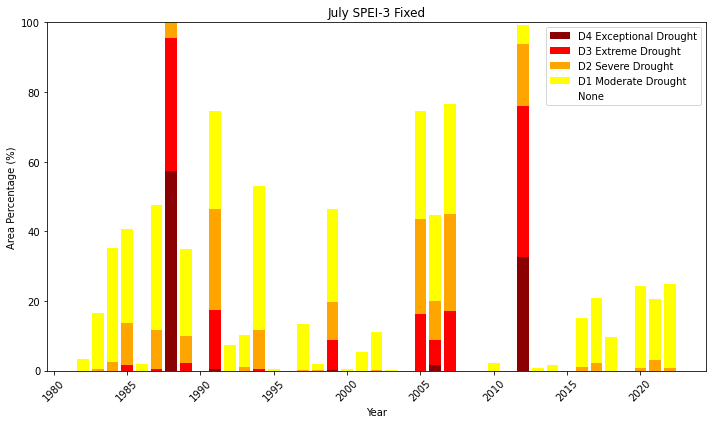

In [193]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Load the data
data = xr.open_dataset("SPEI3_CHIRPS_clipped_by_mask_with_CRS.nc")

# Extract the SPEI data
spei_data = data['spei']

# Define the years (1982-2022)
years = np.arange(1982, 2023)

# Initialize lists to store the percentage of each category
d4_percents = []
d3_percents = []
d2_percents = []
d1_percents = []
none_percents = []

# Loop over each year to extract the July band and classify the data
for year in years:
    # Calculate the band number for July of the given year
    # Band 1 is January 1981, so Band 19 is July 1982
    band_number = (year - 1981) * 12 + 7  # Adjusting for correct band numbers
    
    # Extract the SPEI values for July of the current year
    spei_july = spei_data.isel(time=band_number - 1)  # Band numbers are 1-based in the file, so subtract 1
    
    # Classify the SPEI (Manually change the threhsolds to fixed or impacts-based)
    d4_year = spei_july.where((spei_july > -5) & (spei_july <= -2), drop=True)
    d3_year = spei_july.where((spei_july > -2) & (spei_july <= -1.6), drop=True)
    d2_year = spei_july.where((spei_july > -1.6) & (spei_july <= -1.3), drop=True)
    d1_year = spei_july.where((spei_july > -1.3) & (spei_july <= -0.8), drop=True)
    none_year = spei_july.where((spei_july > -0.8) & (spei_july <= 5), drop=True)

    total_pixels = spei_july.count()  # Total valid (non-NaN) pixels

    
    # Calculate the number of pixels in each category
    d4_count = d4_year.count()
    d3_count = d3_year.count()
    d2_count = d2_year.count()
    d1_count = d1_year.count()
    none_count = none_year.count()
    
    # Calculate the area percentage for each category based on valid pixels
    d4_percent = (d4_count / total_pixels) * 100 if total_pixels > 0 else 0
    d3_percent = (d3_count / total_pixels) * 100 if total_pixels > 0 else 0
    d2_percent = (d2_count / total_pixels) * 100 if total_pixels > 0 else 0
    d1_percent = (d1_count / total_pixels) * 100 if total_pixels > 0 else 0
    none_percent = (none_count / total_pixels) * 100 if total_pixels > 0 else 0

    # Append the results
    d4_percents.append(d4_percent)
    d3_percents.append(d3_percent)
    d2_percents.append(d2_percent)
    d1_percents.append(d1_percent)
    none_percents.append(none_percent)

# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(years, d4_percents, color='darkred', label="D4 Exceptional Drought")
ax.bar(years, d3_percents, bottom=d4_percents, color='red', label="D3 Extreme Drought")
ax.bar(years, d2_percents, bottom=np.array(d4_percents) + np.array(d3_percents), color='orange', label="D2 Severe Drought")
ax.bar(years, d1_percents, bottom=np.array(d4_percents) + np.array(d3_percents) + np.array(d2_percents), color='yellow', label="D1 Moderate Drought")
ax.bar(years, none_percents, bottom=np.array(d4_percents) + np.array(d3_percents) + np.array(d2_percents) + np.array(d1_percents), color='white', label="None")

# Labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Area Percentage (%)')
ax.set_title('July SPEI-3 Fixed')
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<xarray.Dataset>
Dimensions:                        (band: 492, x: 386, y: 157)
Coordinates:
  * band                           (band) int64 1 2 3 4 5 ... 489 490 491 492
  * x                              (x) float64 -96.6 -96.56 ... -80.59 -80.55
  * y                              (y) float64 36.98 37.02 37.06 ... 43.45 43.49
Data variables:
    spatial_ref                    int64 ...
    __xarray_dataarray_variable__  (band, y, x) float32 ...


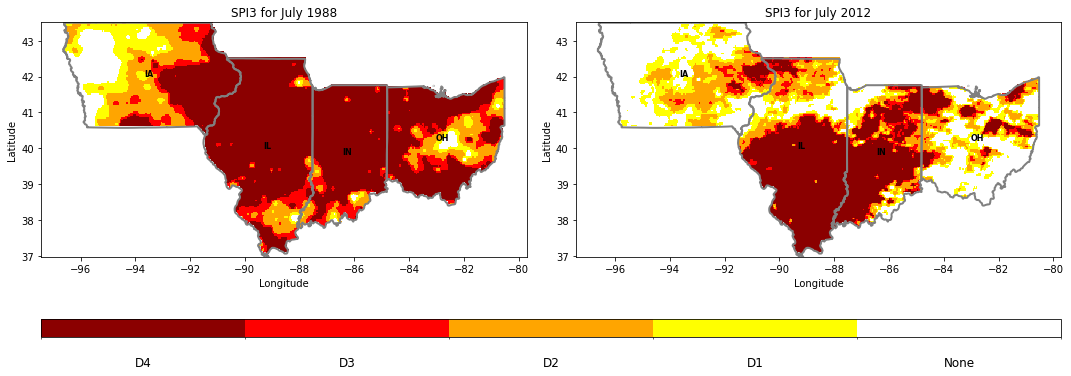

In [189]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec

# Load the SPI3 NetCDF file
nc_file = "SPI3_clipped_by_mask_with_CRS.nc"
ds = xr.open_dataset(nc_file)

# Check the variable name in the dataset
print(ds)

# Select Bands for June and July 2012
band_indices = [79 - 1, 367 - 1]  # Convert to 0-based indices (June 2012, July 2012)
spi_data = [ds["__xarray_dataarray_variable__"].isel(band=band_index) for band_index in band_indices]  # Replace with correct variable name

# Load the shapefile
shapefile = "4states.shp"
gdf = gpd.read_file(shapefile)

# Classify the SPI data (Manually change the threhsolds to fixed or impacts-based)
class_bins = [-5, -1, -0.8, -0.4, -0.1, 5]
class_colors = ["darkred", "red", "orange", "yellow", "white"]  # White for "None"
class_labels = ["D4", "D3", "D2", "D1", "None"]

# Create a colormap and normalization
cmap = ListedColormap(class_colors)
norm = BoundaryNorm(class_bins, cmap.N)

# Create a figure and gridspec to control layout
fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 0.05])  # Create 2 rows, 1 for plots and 1 for colorbar

# Define the titles for the subplots
titles = [
    "SPI3 for July 1988",
    "SPI3 for July 2012"
]

# Create subplots in the gridspec layout
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

# Plot the data for each subplot
for i, ax in enumerate([ax0, ax1]):
    im = spi_data[i].plot.imshow(
        ax=ax,
        cmap=cmap,
        norm=norm,
        add_colorbar=False  # Disable default colorbar to customize it
    )
    
    # Overlay the shapefile
    gdf.boundary.plot(ax=ax, edgecolor="grey", linewidth=2)
    
    # Add the STUSPS labels at the centroid of each polygon
    for _, row in gdf.iterrows():
        # Get the centroid coordinates for the polygon
        centroid = row.geometry.centroid
        ax.text(
            centroid.x, centroid.y, row['STUSPS'], ha='center', va='center', fontsize=8, color='black', fontweight='bold'
        )
    
    # Add a title to each subplot
    ax.set_title(titles[i])
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

# Add a single colorbar for both subplots
cbar_ax = fig.add_subplot(gs[1, :])  # Colorbar occupies the bottom row
cbar = fig.colorbar(
    im,  # Pass the ScalarMappable object from the last subplot
    cax=cbar_ax,  # Use the colorbar axis
    orientation="horizontal",
    fraction=0.05,  # Colorbar height as a fraction of the plot height
    pad=0.1,  # Minimal distance from the main plot
)

# Remove ticks and labels from the colorbar
cbar.set_ticks([])  # Remove tick marks
cbar.set_ticklabels([])  # Remove class names

# Manually add the labels below each color segment
label_positions = [(class_bins[i] + class_bins[i + 1]) / 2 for i in range(len(class_bins) - 1)]
for j, label in enumerate(class_labels):
    cbar.ax.text(label_positions[j], -1, label, ha='center', va='top', fontsize=12)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

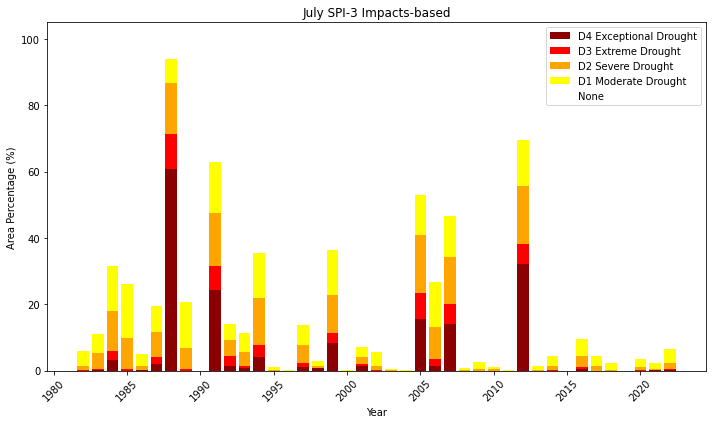

In [198]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Load the data
data = xr.open_dataset("SPI3_clipped_by_mask_with_CRS.nc")

# Extract the SPEI data
spi_data = data['__xarray_dataarray_variable__']

# Define the years (1982-2022)
years = np.arange(1982, 2023)

# Initialize lists to store the percentage of each category
d4_percents = []
d3_percents = []
d2_percents = []
d1_percents = []
none_percents = []

# Loop over each year to extract the July band and classify the data
for year in years:
    # Calculate the band number for July of the given year
    # Band 1 is January 1982
    band_number = (year - 1982) * 12 + 7  # Adjusting for correct band numbers
    
    # Extract the SPI values for July of the current year
    spi_july = spi_data.isel(band=band_number - 1)  # Band numbers are 1-based in the file, so subtract 1
    
    # Classify the SPEI values (Manually change the threhsolds to fixed or impacts-based)
    d4_year = spi_july.where((spi_july > -5) & (spi_july <= -1), drop=True)
    d3_year = spi_july.where((spi_july > -1) & (spi_july <= -0.8), drop=True)
    d2_year = spi_july.where((spi_july > -0.8) & (spi_july <= -0.4), drop=True)
    d1_year = spi_july.where((spi_july > -0.4) & (spi_july <= -0.1), drop=True)
    none_year = spi_july.where((spi_july > -0.1) & (spi_july <= 5), drop=True)

    total_pixels = spi_july.count()  # Total valid (non-NaN) pixels

    
    # Calculate the number of pixels in each category
    d4_count = d4_year.count()
    d3_count = d3_year.count()
    d2_count = d2_year.count()
    d1_count = d1_year.count()
    none_count = none_year.count()
    
    # Calculate the area percentage for each category based on valid pixels
    d4_percent = (d4_count / total_pixels) * 100 if total_pixels > 0 else 0
    d3_percent = (d3_count / total_pixels) * 100 if total_pixels > 0 else 0
    d2_percent = (d2_count / total_pixels) * 100 if total_pixels > 0 else 0
    d1_percent = (d1_count / total_pixels) * 100 if total_pixels > 0 else 0
    none_percent = (none_count / total_pixels) * 100 if total_pixels > 0 else 0

    # Append the results
    d4_percents.append(d4_percent)
    d3_percents.append(d3_percent)
    d2_percents.append(d2_percent)
    d1_percents.append(d1_percent)
    none_percents.append(none_percent)

# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(years, d4_percents, color='darkred', label="D4 Exceptional Drought")
ax.bar(years, d3_percents, bottom=d4_percents, color='red', label="D3 Extreme Drought")
ax.bar(years, d2_percents, bottom=np.array(d4_percents) + np.array(d3_percents), color='orange', label="D2 Severe Drought")
ax.bar(years, d1_percents, bottom=np.array(d4_percents) + np.array(d3_percents) + np.array(d2_percents), color='yellow', label="D1 Moderate Drought")
ax.bar(years, none_percents, bottom=np.array(d4_percents) + np.array(d3_percents) + np.array(d2_percents) + np.array(d1_percents), color='white', label="None")

# Labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Area Percentage (%)')
ax.set_title('July SPI-3 Impacts-based')
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [195]:
import xarray as xr

# Path to the NetCDF file
netcdf_file = "SPI3_clipped_by_mask_with_CRS.nc"

# Load the NetCDF dataset
ds = xr.open_dataset(netcdf_file)

# Print dataset details
print("NetCDF Dataset:")
print(ds)

# List all variables and dimensions
print("\nVariables:")
print(ds.variables)

# List dimensions
print("\nDimensions:")
print(ds.dims)

# Inspect the 'time


NetCDF Dataset:
<xarray.Dataset>
Dimensions:                        (band: 492, x: 386, y: 157)
Coordinates:
  * band                           (band) int64 1 2 3 4 5 ... 489 490 491 492
  * x                              (x) float64 -96.6 -96.56 ... -80.59 -80.55
  * y                              (y) float64 36.98 37.02 37.06 ... 43.45 43.49
Data variables:
    spatial_ref                    int64 ...
    __xarray_dataarray_variable__  (band, y, x) float32 ...

Variables:
Frozen({'band': <xarray.IndexVariable 'band' (band: 492)>
array([  1,   2,   3, ..., 490, 491, 492]), 'x': <xarray.IndexVariable 'x' (x: 386)>
array([-96.600739, -96.559036, -96.517334, ..., -80.628769, -80.587067,
       -80.545364])
Attributes:
    axis:           X
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east, 'y': <xarray.IndexVariable 'y' (y: 157)>
array([36.979469, 37.021202, 37.062935, 37.104668, 37.1464  , 37.188133,
       37.229866, 37.271599, 37.313332, 37.3